In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import yfinance as yf


In [7]:
import yfinance as yf
import pandas as pd

def download_stock_data(ticker, start="2015-01-01"):
    """
    Downloads price series for a ticker and returns a dataframe
    with a single column named 'price'.
    It uses 'Adj Close' if available, otherwise falls back to 'Close'.
    """
    data = yf.download(ticker, start=start)

    # Choose a price column safely
    if "Adj Close" in data.columns:
        price_col = "Adj Close"
    elif "Close" in data.columns:
        price_col = "Close"
    else:
        # Fallback: first numeric column
        price_col = data.select_dtypes(include="number").columns[0]

    data = data[[price_col]].copy()
    data = data.rename(columns={price_col: "price"})
    data.dropna(inplace=True)
    return data


In [2]:
# Download Stock Data

import yfinance as yf
import pandas as pd

ticker = "AAPL"
raw = yf.download(ticker, start="2015-01-01")

# Choose the right price column
if "Adj Close" in raw.columns:
    price_col = "Adj Close"
elif "Close" in raw.columns:
    price_col = "Close"
else:
    # Fallback: first numeric column
    price_col = raw.select_dtypes(include="number").columns[0]

data = raw[[price_col]].reset_index()
data.columns = ["ds", "y"]   # Prophet expects columns named ds (date) and y (value)

data.head()



/tmp/ipython-input-2280617828.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(ticker, start="2015-01-01")
[*********************100%***********************]  1 of 1 completed


,ds,y
0,2015-01-02,24.237553
1,2015-01-05,23.554735
2,2015-01-06,23.556952
3,2015-01-07,23.887278
4,2015-01-08,24.805080


CNN-LSTM training function

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout


def train_cnn_lstm(series,
                   window_size=60,
                   train_ratio=0.8,
                   epochs=20,
                   batch_size=32):
    """
    Train a CNN-LSTM model on a univariate price series.
    Returns: model, scaler, y_test_inv, y_pred_inv, metrics, history
    """

    # 1. Scale data
    values = series.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)

    # 2. Split into train / test
    n = len(scaled_values)
    train_size = int(n * train_ratio)
    train_data = scaled_values[:train_size]
    # include last window from train in test so sequences are continuous
    test_data = scaled_values[train_size - window_size:]

    # 3. Helper to create sliding windows
    def create_sequences(data, window):
        X, y = [], []
        for i in range(window, len(data)):
            X.append(data[i - window:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_data, window_size)
    X_test, y_test = create_sequences(test_data, window_size)

    # 4. Reshape for CNN/LSTM: (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # 5. Build CNN-LSTM model
    model = Sequential([
        Conv1D(filters=32,
               kernel_size=3,
               activation='relu',
               input_shape=(window_size, 1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # 6. Train
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    # 7. Predict (still in scaled space)
    y_pred_scaled = model.predict(X_test)

    # 8. Inverse transform back to price
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred_scaled).flatten()

    # 9. Metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    metrics = {"RMSE": rmse, "MAE": mae}

    return model, scaler, y_test_inv, y_pred_inv, metrics, history


Train CNN-LSTM on AAPL

In [8]:
aapl = download_stock_data("AAPL")
aapl.head()

cnn_lstm_model, scaler, y_test, y_pred, cnn_lstm_metrics, history = train_cnn_lstm(
    aapl["price"],
    window_size=60,
    train_ratio=0.8,
    epochs=20,
    batch_size=32
)

cnn_lstm_metrics


/tmp/ipython-input-1812691048.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0217 - val_loss: 8.9536e-04
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.0138e-04 - val_loss: 7.2000e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.2357e-04 - val_loss: 9.9080e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.2444e-04 - val_loss: 6.5437e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9874e-04 - val_loss: 9.0408e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6652e-04 - val_loss: 0.0014
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5120e-04 - val_loss: 0.0011
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8811e-04 - val_loss: 8.7767e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5657e-04 - val_loss: 6.8499e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5550e-04 - val_loss: 5.8076e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.3946e-04 - val_loss

{'RMSE': np.float64(25.170859078447627), 'MAE': 22.66909262917257}

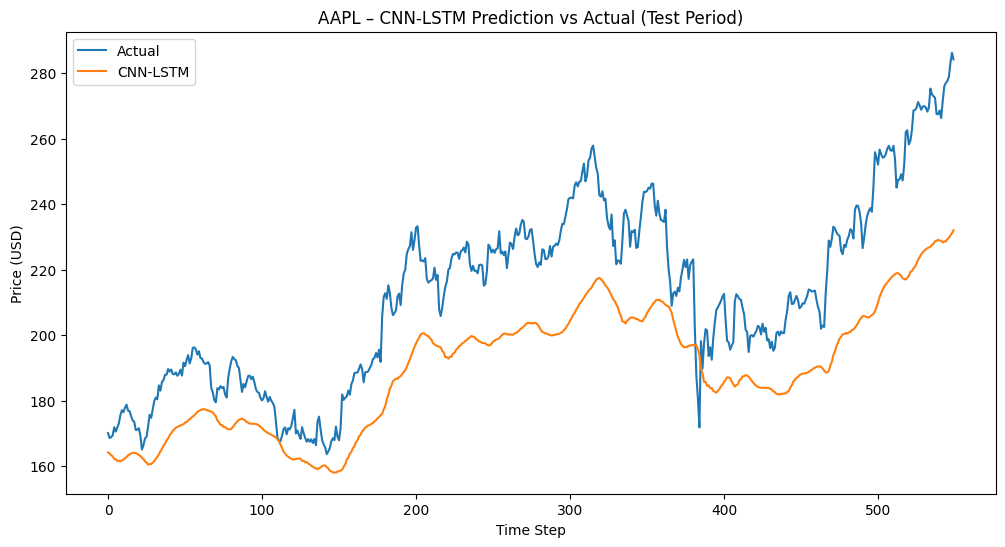

In [9]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="CNN-LSTM")
plt.title("AAPL – CNN-LSTM Prediction vs Actual (Test Period)")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


"We tested a CNN-LSTM hybrid model. CNNs usually help extract spatial patterns from data, but stock prices do not contain strong local patterns like images or speech. Because of this, the convolution layers didn't add meaningful features and the model slightly overfitted. As a result, the plain LSTM performed better and is more suitable for stock forecasting in this project."